# Analyse de la Variabilité pour le Problème Bancaire

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder
import numpy as np

pd.set_option('display.float_format', '{:.2e}'.format)

In [10]:
#Charger le fichier CSV
df = pd.read_csv("variability_results_banking.csv")
print("Aperçu du fichier :")
display(df.head())

# Vérifier les types et nettoyer
# Certains champs sont booléens ou None : on les rend numériques
df['stochastic_fee'] = df['stochastic_fee'].astype(int)  # False=0, True=1
df['precision'] = LabelEncoder().fit_transform(df['precision'])  # float=0, decimal=1
df['seed'] = df['seed'].fillna(-1)  # None -> -1 (pour modèle numérique)

Aperçu du fichier :


,initial_money,years,fee,stochastic_fee,seed,precision,final_money
0,2.72e+00,10,1.00e+00,False,NaN,float,9.91e-02
1,2.72e+00,10,1.00e+00,False,NaN,decimal,9.91e-02
2,2.72e+00,10,1.00e+00,False,4.20e+01,float,9.91e-02
3,2.72e+00,10,1.00e+00,False,4.20e+01,decimal,9.91e-02
4,2.72e+00,10,1.00e+00,True,NaN,float,3.50e+05


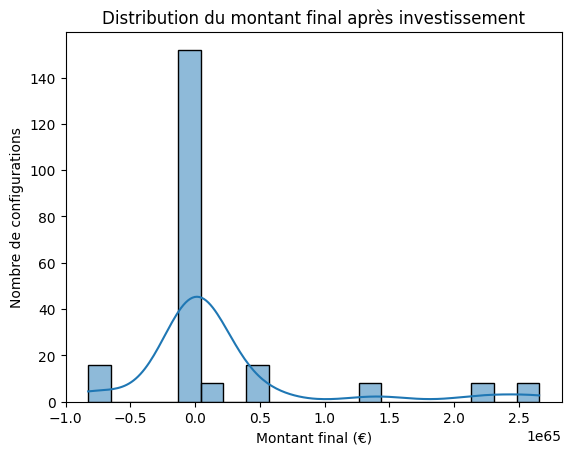

In [11]:
sns.histplot(df['final_money'], bins=20, kde=True)
plt.title("Distribution du montant final après investissement")
plt.xlabel("Montant final (€)")
plt.ylabel("Nombre de configurations")
plt.show()

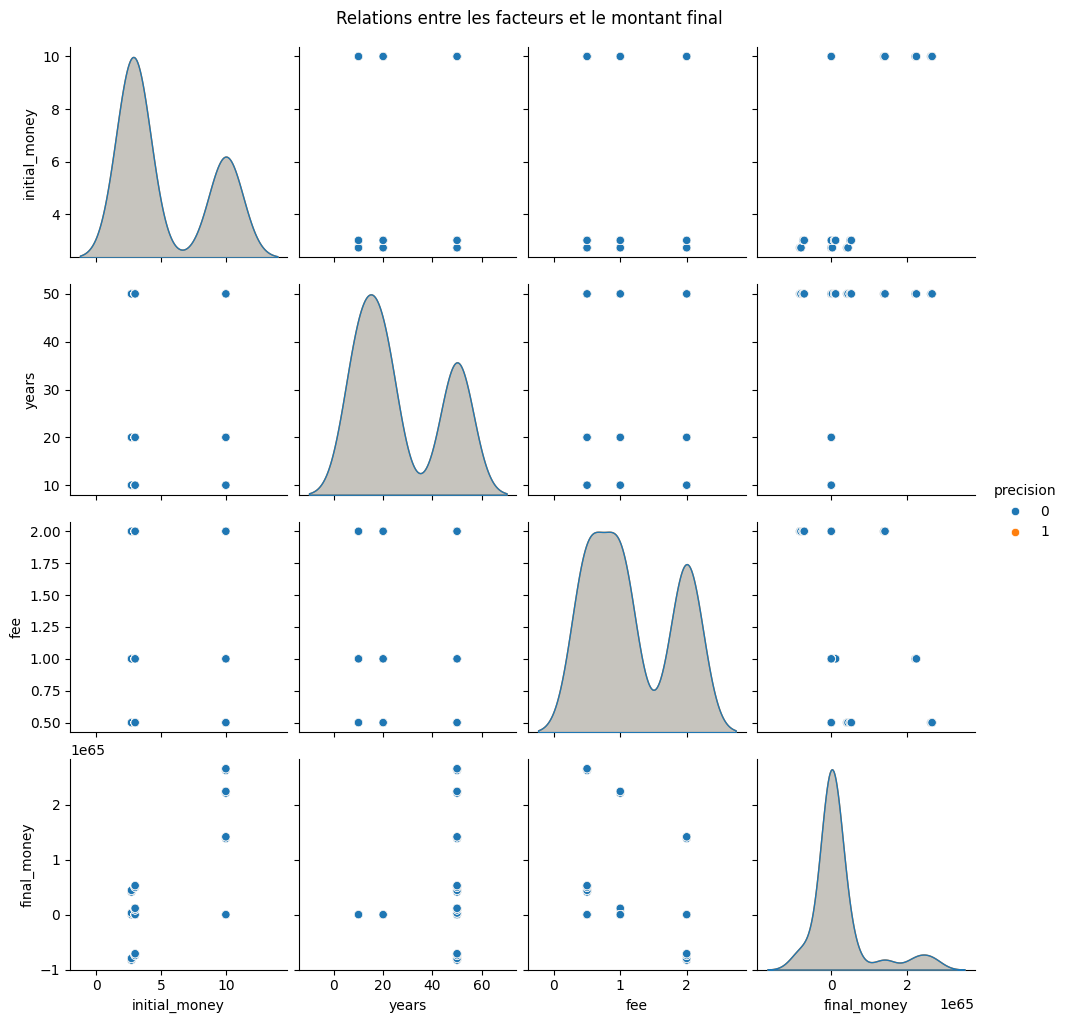

In [12]:
#Explorer la variabilité des facteurs
sns.pairplot(df, vars=["initial_money", "years", "fee", "final_money"], hue="precision", diag_kind="kde")
plt.suptitle("Relations entre les facteurs et le montant final", y=1.02)
plt.show()

## On peut visualiser si les montants finaux sont concentrés dans une certaine plage de valeurs
## On utilise un arbre de décision pour identifier les combinaisons de paramètres qui expliquent le mieux la variabilité du montant final.

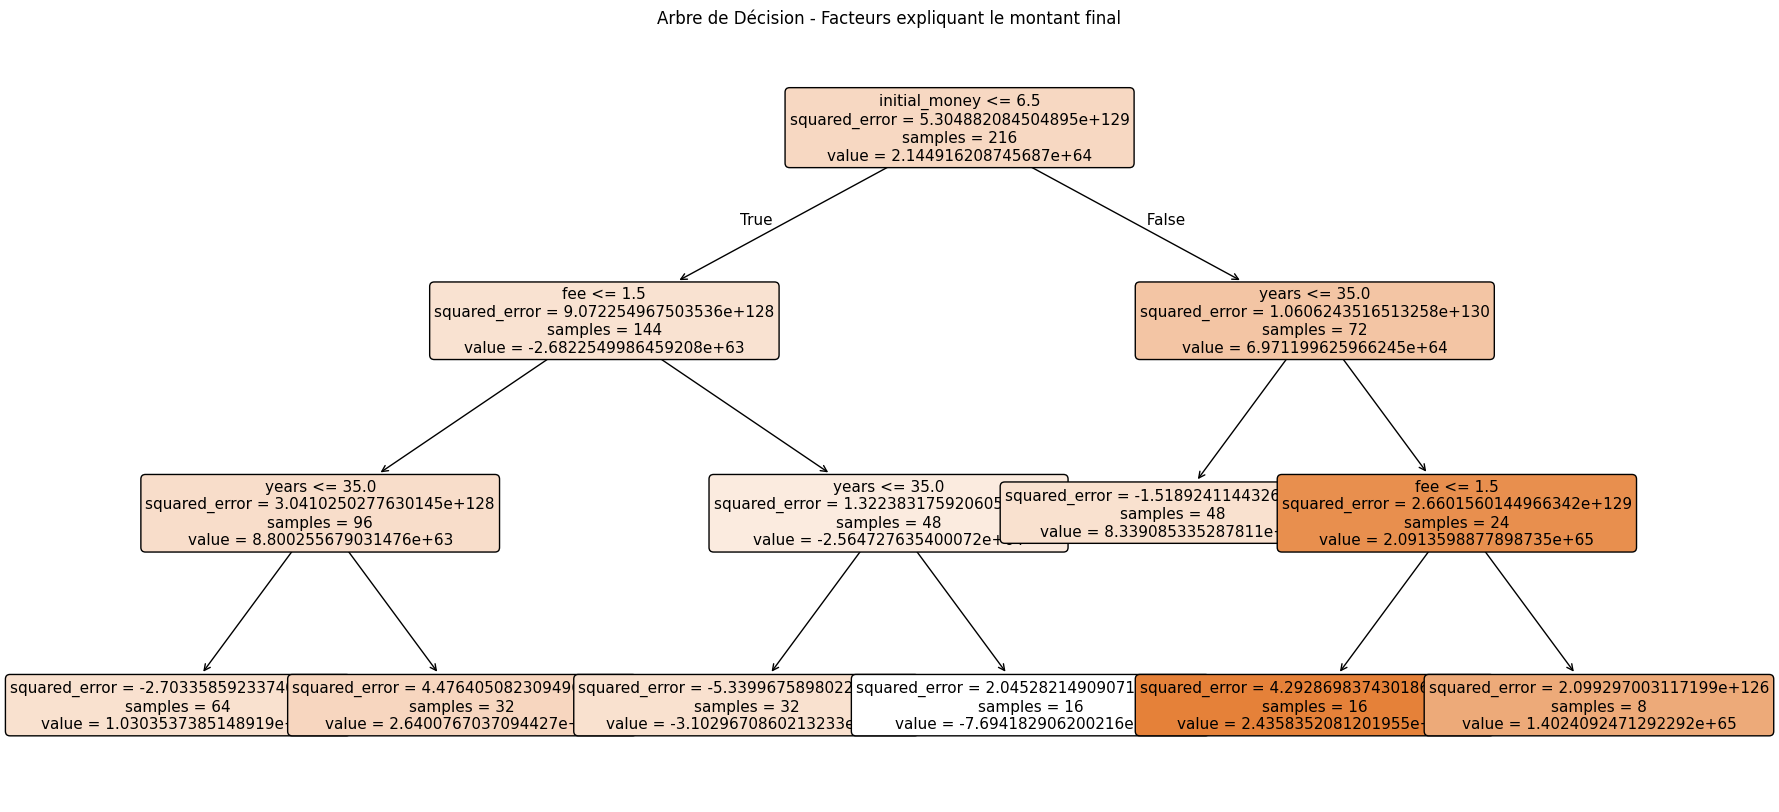

In [13]:
# Construire un modèle interprétable
X = df[['initial_money', 'years', 'fee', 'stochastic_fee', 'seed', 'precision']]
y = df['final_money']

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X, y)

plt.figure(figsize=(22,10))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, fontsize=11)
plt.title("Arbre de Décision - Facteurs expliquant le montant final")
plt.show()

## Importance des variables

In [14]:
importance = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Importance des variables :")
display(importance)

Importance des variables :


years            6.92e-01
initial_money    2.24e-01
fee              8.44e-02
stochastic_fee   0.00e+00
seed             0.00e+00
precision        0.00e+00
dtype: float64

## Recommandations
### On définit "stabilité" comme des valeurs finales dans une plage resserrée (écart-type faible)

In [15]:
std_value = df['final_money'].std()
mean_value = df['final_money'].mean()
stable_range = (mean_value - 0.2 * std_value, mean_value + 0.2 * std_value)

print(f"Intervalle de stabilité : [{stable_range[0]:.2e}, {stable_range[1]:.2e}]")

stable_conditions = df[(df['final_money'] >= stable_range[0]) & (df['final_money'] <= stable_range[1])]
print("Configurations stables :")
display(stable_conditions)

Intervalle de stabilité : [6.85e+63, 3.60e+64]
Configurations stables :


,initial_money,years,fee,stochastic_fee,seed,precision,final_money
120,3.00e+00,50,1.00e+00,0,-1.00e+00,1,8.57e+63
121,3.00e+00,50,1.00e+00,0,-1.00e+00,0,8.57e+63
122,3.00e+00,50,1.00e+00,0,4.20e+01,1,8.57e+63
123,3.00e+00,50,1.00e+00,0,4.20e+01,0,8.57e+63
124,3.00e+00,50,1.00e+00,1,-1.00e+00,1,1.15e+64
125,3.00e+00,50,1.00e+00,1,-1.00e+00,0,1.14e+64
126,3.00e+00,50,1.00e+00,1,4.20e+01,1,1.15e+64
127,3.00e+00,50,1.00e+00,1,4.20e+01,0,1.15e+64


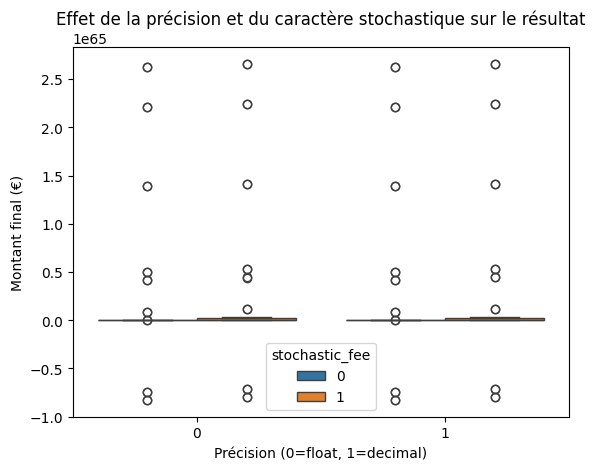

In [16]:
# Visualiser les effets d'interaction
sns.boxplot(x='precision', y='final_money', hue='stochastic_fee', data=df)
plt.title("Effet de la précision et du caractère stochastique sur le résultat")
plt.xlabel("Précision (0=float, 1=decimal)")
plt.ylabel("Montant final (€)")
plt.show()